In [1]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve

# Midterm Project for the Machine Learning Zoomcamp (DataTalks.Club)
For the midterm project I have chosen a dataset from kaggle containing diabetes risk factors and the corresponding information whether diabetes has been diagnosed for a total of 768 patiens. The dataset can be downloaded [here](https://www.kaggle.com/datasets/akshaydattatraykhare/diabetes-dataset).


## Exploratory Data Analysis (EDA)

Information on the features:

Pregnancies: To express the Number of pregnancies

Glucose: To express the Glucose level in blood

BloodPressure: To express the Blood pressure measurement

SkinThickness: To express the thickness of the skin

Insulin: To express the Insulin level in blood

BMI: To express the Body mass index

DiabetesPedigreeFunction: To express the Diabetes percentage

Age: To express the age

Outcome: To express the final result 1 is Yes and 0 is No

In [2]:
# Loading the data
data = pd.read_csv('../data/diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


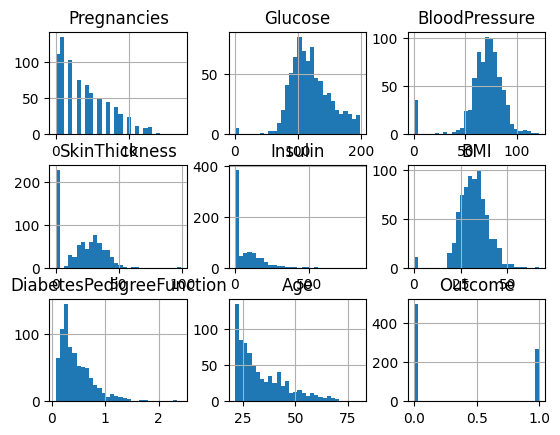

In [4]:
# Sloppy visualisation
data.hist(bins=30);

We can see that ...

1. the target is imbalanced. Since diabetes in the general population also is imbalanced, we won't rebalance the sample occurances. Instead, we will pick the hyperparam class_weight='balanced' for the model instantiation.

2. there are several impossible/improbable values showing as '0' in 'SkinThinkness', 'BMI', 'BloodPressure', 'Glucose' and maybe also in 'Insulin' (although this might not be as improbable as for the other features). Also 'Age' has suspiciously many '0'-values, although I imagine that babies whose mothers suffered from gestational diabetes are regularly tested for the disease (and might more often be diagnosed). If this was not only a study project, I would seek domain knowledge from experts for shetting light on those '0'-values. For the purpose at hand, I will percede by substituting the '0'-values with the medians, except for 'Age', which I will leave as it is.


In [5]:
data.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

There are no explicit NaN values.

## Preprocessing

In [6]:
# Train Test Split

X = data.iloc[:, :-1]
y = data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

We need to do the train test split before preprocessing the data, so we avoid data leakage.

In [7]:
# Substituting '0'-values with the column's medians
def substituting_nan_values(X, columns):
    for column in columns:
        X[column] = X[column].replace(0,X[column].mean())
    return X

In [8]:
columns_to_fillna = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'Insulin']
substituting_nan_values(X_train, columns_to_fillna)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
374,2,122.0,52.0,43.000000,158.000000,36.200000,0.816,28
224,1,100.0,66.0,15.000000,56.000000,23.600000,0.666,26
371,0,118.0,64.0,23.000000,89.000000,31.875419,1.731,21
143,10,108.0,66.0,20.454376,80.288641,32.400000,0.272,42
210,2,81.0,60.0,22.000000,80.288641,27.700000,0.290,25
...,...,...,...,...,...,...,...,...
515,3,163.0,70.0,18.000000,105.000000,31.600000,0.268,28
408,8,197.0,74.0,20.454376,80.288641,25.900000,1.191,39
256,3,111.0,56.0,39.000000,80.288641,30.100000,0.557,30
358,12,88.0,74.0,40.000000,54.000000,35.300000,0.378,48


<AxesSubplot:>

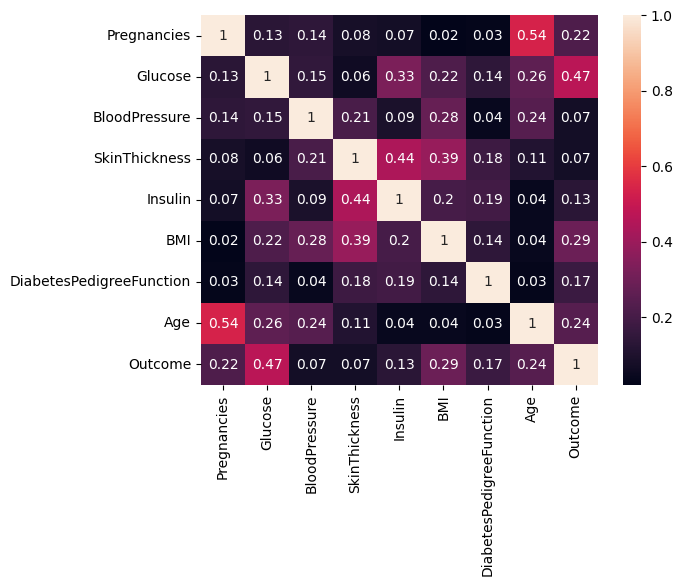

In [9]:
# Check on correlations

sns.heatmap(data.corr().abs().round(2),annot=True)

The correlations between 'Age' and 'Pregnancies' and between 'BMI' and 'SkinThickness' are quite high. So, for model training we'll experiment with leaving out either from both pairs to see if the model performance will increase.

In [10]:
# Scaling the data
def scaling_data(X, data):
    scaler = RobustScaler()
    X = pd.DataFrame(scaler.fit(X).transform(X), columns=data.iloc[:,:-1].columns)
    return X

scaling_data(X_train, data)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,-0.2,0.097561,-1.250,1.732258,1.738067,0.471910,1.270492,-0.066667
1,-0.4,-0.439024,-0.375,-0.692903,-0.543232,-0.943820,0.860656,-0.200000
2,-0.6,0.000000,-0.500,0.000000,0.194835,-0.013998,3.770492,-0.533333
3,1.4,-0.243902,-0.375,-0.220484,0.000000,0.044944,-0.215847,0.866667
4,-0.2,-0.902439,-0.750,-0.086613,0.000000,-0.483146,-0.166667,-0.266667
...,...,...,...,...,...,...,...,...
532,0.0,1.097561,-0.125,-0.433065,0.552686,-0.044944,-0.226776,-0.066667
533,1.0,1.926829,0.125,-0.220484,0.000000,-0.685393,2.295082,0.666667
534,0.0,-0.170732,-1.000,1.385806,0.000000,-0.213483,0.562842,0.066667
535,1.8,-0.731707,0.125,1.472419,-0.587963,0.370787,0.073770,1.266667


## Model Selection
We will train different Classifiers roughly and then fine tune the best performing one.

### KNN Classifier

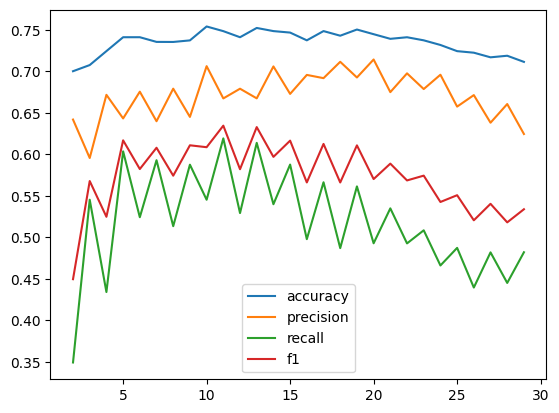

In [11]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for i in range(2, 30):
    knn_model = KNeighborsClassifier(n_neighbors=i) 
    cv_scores = cross_validate(knn_model, X_train, y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])
    accuracy_scores.append(cv_scores['test_accuracy'].mean())
    precision_scores.append(cv_scores['test_precision'].mean())
    recall_scores.append(cv_scores['test_recall'].mean())
    f1_scores.append(cv_scores['test_f1'].mean())

accuracy_scores

sns.lineplot(x=[i for i in range(2, 30)], y=accuracy_scores, label='accuracy')
sns.lineplot(x=[i for i in range(2, 30)], y=precision_scores, label='precision')
sns.lineplot(x=[i for i in range(2, 30)], y=recall_scores, label='recall')
sns.lineplot(x=[i for i in range(2, 30)], y=f1_scores, label='f1');

### Logistic Regression

In [12]:
logreg_model = LogisticRegression(class_weight='balanced')
cv_scores = cross_validate(logreg_model, X_train, y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

accuracy = cv_scores['test_accuracy'].mean()
precision = cv_scores['test_precision'].mean()
recall = cv_scores['test_recall'].mean()
f1 = cv_scores['test_f1'].mean()

accuracy, precision, recall, f1

(0.7615957078573901, 0.6445816767560412, 0.72475106685633, 0.6815401333358644)

We can already detect, that the vanilla Logistic Regression has a highter F1 score than the KNN Classifier. Since the F1 score is the harmonic mean between precision and recall, balancing best their tradeof, we should consider it as the most important evaluation metric for evuating a model.

### Support Vector Machine

In [13]:
svm_model = SVC(kernel='linear', C=1, class_weight='balanced')
cv_scores = cross_validate(svm_model, X_train, y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

accuracy = cv_scores['test_accuracy'].mean()
precision = cv_scores['test_precision'].mean()
recall = cv_scores['test_recall'].mean()
f1 = cv_scores['test_f1'].mean()

accuracy, precision, recall, f1

(0.7671685704395985, 0.6531359329293822, 0.72475106685633, 0.6862492012827083)

The SVMs F1 score is in a comparable range. Let's try to fine tune the SVM then (because I want to get used to SVM more).

## Model Fine Tuning

In [14]:
svm_model = SVC()

param_grid = [{
        "C": [0.5, 0.7, 1.0, 1.25],
        "kernel": ['linear', 'rbf', 'sigmoid'],
        "gamma": ['scale', 'auto'],
        "class_weight": ['balanced', None]
        }]

grid_search = GridSearchCV(svm_model, param_grid, scoring='f1', cv=5, verbose=1)
grid_search.fit(X_train, y_train)
grid_search.best_score_


Fitting 5 folds for each of 48 candidates, totalling 240 fits


0.6880947241808628

In [15]:
grid_search.best_params_

{'C': 0.7, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}

After the grid search the SVM model has increased the F1 score by some percentages. Let's also experiment with feature selection for a moment:

In [16]:
X_without_pregnancies = X_train.drop(columns=['Pregnancies'])
X_without_skinthickness = X_train.drop(columns=['SkinThickness'])

feature_selection_list = [X_train, X_without_pregnancies, X_without_skinthickness]

svm_model = SVC(kernel='rbf', gamma='scale', C=1, class_weight='balanced')

for feature_set in feature_selection_list: 
    cv_scores = cross_validate(svm_model, feature_set, y_train, cv=5, scoring='f1')
    f1 = cv_scores['test_score'].mean()
    print(f'F1-score: {f1}')

F1-score: 0.6513478086859769
F1-score: 0.6532609328116898
F1-score: 0.6462184727829579


Despite some correlation (as we have seen above when plotting the heat map), the model still performs best when taking all of the features into account.

## Model Training

In [17]:
# Training the model

svm_model = SVC(kernel='rbf', gamma='scale', C=1, class_weight='balanced')
svm_model.fit(X_train, y_train)

SVC(C=1, class_weight='balanced')

## Exporting final model into a pickle file

In [18]:
output_file = '../scripts/svm_model.bin'

with open(output_file, 'wb') as f_out:
    pickle.dump(svm_model, f_out)

## Loading model

In [19]:
model_file = '../scripts/svm_model.bin'

with open(model_file, 'rb') as f_in:
    model = pickle.load(f_in)


## Predict and model evaluation

In [20]:
# Predict for test data
y_pred = svm_model.predict(X_test)

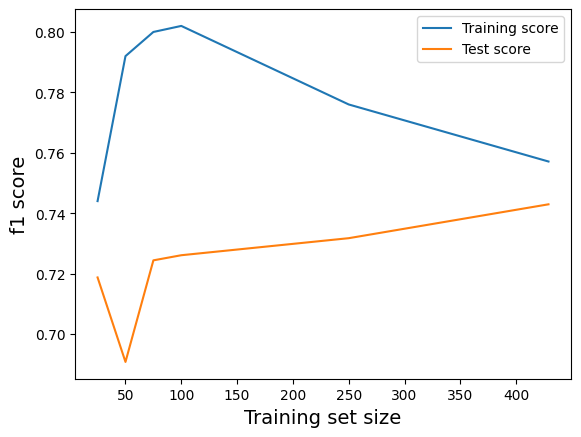

In [21]:
# Evaluating the model

train_sizes = [25,50,75,100,250,429]

train_sizes, train_scores, test_scores = learning_curve(
    estimator=svm_model, X=X_train, y=y_train, train_sizes=train_sizes, cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('f1 score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.legend()

We can see, that the lines don't converge yet, but if we would be getting more data, the model was likely to fit well enough.